# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Sat May  3 12:18:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P5             17W /   40W |     730MiB /   6144MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [42]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [43]:
# Importaj sve potrebno iz gan_skripta.py
from gan import (
    CycleGANConfig,
    UNetGenerator,
    train_cyclegan,  # Glavna funkcija za treniranje
    get_stratified_data_loaders,  # Koristimo funkciju za stratificiranu podjelu
    plot_training_curves, 
    visualize_results, 
    test_model,
    test_model_fixed_crop
)

ImportError: cannot import name 'test_model_fixed_crop' from 'gan' (/home/matejav_diplomski/masterThesis/notebooks/gan.py)

In [5]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model",
    checkpoints_dir="../checkpoints/standard_model",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=100,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=20,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=10,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [6]:
# Stvaranje direktorija za rezultate i checkpointe ako ne postoje
os.makedirs(config.results_dir, exist_ok=True)
os.makedirs(config.checkpoints_dir, exist_ok=True)

# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 100
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [7]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 48 trening, 10 validacija, 11 test
Podjela regularnih slika: 352 trening, 75 validacija, 76 test
Ukupna podjela: 400 trening, 85 validacija, 87 test


In [8]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

Epoha 1/100: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, D_A_loss=0.3851, D_B_loss=0.1148, G_loss=3.7550] 


Epoha 1/100 - Train gubici: G: 10.0918, D_A: 0.5232, D_B: 0.7179 | Val gubici: G: 2.3119, Cycle: 1.6571
Novi najbolji validacijski gubitak: 1.6571, spremam modele...


Epoha 2/100: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, D_A_loss=0.2247, D_B_loss=0.3081, G_loss=2.0802]


Epoha 2/100 - Train gubici: G: 2.7931, D_A: 0.2347, D_B: 0.1898 | Val gubici: G: 1.7529, Cycle: 1.2723
Novi najbolji validacijski gubitak: 1.2723, spremam modele...


Epoha 3/100: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s, D_A_loss=0.2784, D_B_loss=0.1655, G_loss=2.0510]


Epoha 3/100 - Train gubici: G: 2.1807, D_A: 0.2505, D_B: 0.2298 | Val gubici: G: 1.5155, Cycle: 0.9706
Novi najbolji validacijski gubitak: 0.9706, spremam modele...


Epoha 4/100: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s, D_A_loss=0.2382, D_B_loss=0.2250, G_loss=2.2958]


Epoha 4/100 - Train gubici: G: 2.0171, D_A: 0.2544, D_B: 0.2304 | Val gubici: G: 1.5197, Cycle: 0.9031
Novi najbolji validacijski gubitak: 0.9031, spremam modele...


Epoha 5/100: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s, D_A_loss=0.2462, D_B_loss=0.2369, G_loss=1.8846]


Epoha 5/100 - Train gubici: G: 1.8961, D_A: 0.2508, D_B: 0.2362 | Val gubici: G: 1.4774, Cycle: 1.0037


Epoha 6/100: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, D_A_loss=0.2130, D_B_loss=0.2811, G_loss=1.8587]


Epoha 6/100 - Train gubici: G: 1.8258, D_A: 0.2490, D_B: 0.2447 | Val gubici: G: 1.3460, Cycle: 0.7845
Novi najbolji validacijski gubitak: 0.7845, spremam modele...


Epoha 7/100: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, D_A_loss=0.2335, D_B_loss=0.2469, G_loss=1.5408]


Epoha 7/100 - Train gubici: G: 1.7431, D_A: 0.2661, D_B: 0.2437 | Val gubici: G: 1.2350, Cycle: 0.7479
Novi najbolji validacijski gubitak: 0.7479, spremam modele...


Epoha 8/100: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, D_A_loss=0.2584, D_B_loss=0.2083, G_loss=1.6896]


Epoha 8/100 - Train gubici: G: 1.6674, D_A: 0.2410, D_B: 0.2400 | Val gubici: G: 1.3833, Cycle: 0.7295
Novi najbolji validacijski gubitak: 0.7295, spremam modele...


Epoha 9/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.2398, D_B_loss=0.2770, G_loss=1.6788]


Epoha 9/100 - Train gubici: G: 1.6871, D_A: 0.2494, D_B: 0.2446 | Val gubici: G: 1.5757, Cycle: 0.8042


Epoha 10/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.2256, D_B_loss=0.2944, G_loss=2.3333]


Epoha 10/100 - Train gubici: G: 1.6474, D_A: 0.2586, D_B: 0.2450 | Val gubici: G: 1.2680, Cycle: 0.7266
Novi najbolji validacijski gubitak: 0.7266, spremam modele...


Epoha 11/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.2582, D_B_loss=0.1956, G_loss=1.5630]


Epoha 11/100 - Train gubici: G: 1.6116, D_A: 0.2490, D_B: 0.2404 | Val gubici: G: 1.2324, Cycle: 0.6709
Novi najbolji validacijski gubitak: 0.6709, spremam modele...


Epoha 12/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.3116, D_B_loss=0.3292, G_loss=2.1950]


Epoha 12/100 - Train gubici: G: 1.5982, D_A: 0.2536, D_B: 0.2408 | Val gubici: G: 1.3121, Cycle: 0.6891


Epoha 13/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.3464, D_B_loss=0.3601, G_loss=1.8666]


Epoha 13/100 - Train gubici: G: 1.5669, D_A: 0.2474, D_B: 0.2335 | Val gubici: G: 1.6913, Cycle: 0.6520
Novi najbolji validacijski gubitak: 0.6520, spremam modele...


Epoha 14/100: 100%|██████████| 100/100 [01:00<00:00,  1.66it/s, D_A_loss=0.2961, D_B_loss=0.3532, G_loss=1.6556]


Epoha 14/100 - Train gubici: G: 1.5520, D_A: 0.2594, D_B: 0.2273 | Val gubici: G: 1.7229, Cycle: 0.7202


Epoha 15/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.2513, D_B_loss=0.2223, G_loss=1.6606]


Epoha 15/100 - Train gubici: G: 1.5821, D_A: 0.2511, D_B: 0.2339 | Val gubici: G: 1.2115, Cycle: 0.6266
Novi najbolji validacijski gubitak: 0.6266, spremam modele...


Epoha 16/100: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s, D_A_loss=0.2515, D_B_loss=0.1800, G_loss=1.2544]


Epoha 16/100 - Train gubici: G: 1.5611, D_A: 0.2765, D_B: 0.2336 | Val gubici: G: 1.1161, Cycle: 0.5895
Novi najbolji validacijski gubitak: 0.5895, spremam modele...


Epoha 17/100: 100%|██████████| 100/100 [01:00<00:00,  1.64it/s, D_A_loss=0.2172, D_B_loss=0.1513, G_loss=1.7001]


Epoha 17/100 - Train gubici: G: 1.4943, D_A: 0.2331, D_B: 0.2247 | Val gubici: G: 1.2574, Cycle: 0.6520


Epoha 18/100: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s, D_A_loss=0.2277, D_B_loss=0.2238, G_loss=1.4479]


Epoha 18/100 - Train gubici: G: 1.4916, D_A: 0.2535, D_B: 0.2254 | Val gubici: G: 1.2049, Cycle: 0.5971


Epoha 19/100: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s, D_A_loss=0.3607, D_B_loss=0.2316, G_loss=2.0466]


Epoha 19/100 - Train gubici: G: 1.5343, D_A: 0.2666, D_B: 0.2199 | Val gubici: G: 1.3647, Cycle: 0.6391


Epoha 20/100: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s, D_A_loss=0.2375, D_B_loss=0.2078, G_loss=1.2405]


Epoha 20/100 - Train gubici: G: 1.4501, D_A: 0.2350, D_B: 0.2131 | Val gubici: G: 1.3480, Cycle: 0.5987


Epoha 21/100: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s, D_A_loss=0.2049, D_B_loss=0.1963, G_loss=1.4002]


Epoha 21/100 - Train gubici: G: 1.5137, D_A: 0.2371, D_B: 0.2145 | Val gubici: G: 1.2912, Cycle: 0.6390


Epoha 22/100: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s, D_A_loss=0.2472, D_B_loss=0.1708, G_loss=1.4661]


Epoha 22/100 - Train gubici: G: 1.5117, D_A: 0.2427, D_B: 0.2094 | Val gubici: G: 1.4329, Cycle: 0.6623


Epoha 23/100: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s, D_A_loss=0.2410, D_B_loss=0.2413, G_loss=1.4393]


Epoha 23/100 - Train gubici: G: 1.5660, D_A: 0.3155, D_B: 0.2117 | Val gubici: G: 1.2811, Cycle: 0.6210


Epoha 24/100: 100%|██████████| 100/100 [00:28<00:00,  3.46it/s, D_A_loss=0.2429, D_B_loss=0.1857, G_loss=1.2643]


Epoha 24/100 - Train gubici: G: 1.3834, D_A: 0.2443, D_B: 0.2062 | Val gubici: G: 1.0719, Cycle: 0.5427
Novi najbolji validacijski gubitak: 0.5427, spremam modele...


Epoha 25/100: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s, D_A_loss=0.2357, D_B_loss=0.1980, G_loss=1.2470]


Epoha 25/100 - Train gubici: G: 1.3828, D_A: 0.2492, D_B: 0.2041 | Val gubici: G: 1.2505, Cycle: 0.5316
Novi najbolji validacijski gubitak: 0.5316, spremam modele...


Epoha 26/100: 100%|██████████| 100/100 [00:28<00:00,  3.48it/s, D_A_loss=0.2929, D_B_loss=0.1957, G_loss=1.2027]


Epoha 26/100 - Train gubici: G: 1.4325, D_A: 0.2561, D_B: 0.2050 | Val gubici: G: 1.0613, Cycle: 0.5869


Epoha 27/100: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s, D_A_loss=0.2178, D_B_loss=0.1919, G_loss=1.1951]


Epoha 27/100 - Train gubici: G: 1.4143, D_A: 0.2484, D_B: 0.2199 | Val gubici: G: 1.0288, Cycle: 0.5265
Novi najbolji validacijski gubitak: 0.5265, spremam modele...


Epoha 28/100: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s, D_A_loss=0.2225, D_B_loss=0.1812, G_loss=1.5625]


Epoha 28/100 - Train gubici: G: 1.3996, D_A: 0.2545, D_B: 0.2089 | Val gubici: G: 1.0116, Cycle: 0.5497


Epoha 29/100: 100%|██████████| 100/100 [00:26<00:00,  3.74it/s, D_A_loss=0.2960, D_B_loss=0.1703, G_loss=1.4519]


Epoha 29/100 - Train gubici: G: 1.4264, D_A: 0.2584, D_B: 0.2129 | Val gubici: G: 1.1407, Cycle: 0.5533


Epoha 30/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.3106, D_B_loss=0.2225, G_loss=1.1280]


Epoha 30/100 - Train gubici: G: 1.3567, D_A: 0.2487, D_B: 0.2101 | Val gubici: G: 1.0770, Cycle: 0.5694


Epoha 31/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2896, D_B_loss=0.2291, G_loss=1.4596]


Epoha 31/100 - Train gubici: G: 1.4150, D_A: 0.2464, D_B: 0.2079 | Val gubici: G: 1.6465, Cycle: 0.6480


Epoha 32/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2277, D_B_loss=0.1783, G_loss=1.4427]


Epoha 32/100 - Train gubici: G: 1.4359, D_A: 0.2545, D_B: 0.2064 | Val gubici: G: 1.3712, Cycle: 0.6158


Epoha 33/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.4060, D_B_loss=0.1697, G_loss=1.7407]


Epoha 33/100 - Train gubici: G: 1.3953, D_A: 0.2508, D_B: 0.2176 | Val gubici: G: 1.0643, Cycle: 0.5802


Epoha 34/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2656, D_B_loss=0.1206, G_loss=1.7179]


Epoha 34/100 - Train gubici: G: 1.3988, D_A: 0.2478, D_B: 0.2011 | Val gubici: G: 1.3581, Cycle: 0.5707


Epoha 35/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2269, D_B_loss=0.1426, G_loss=1.3529]


Epoha 35/100 - Train gubici: G: 1.4082, D_A: 0.2669, D_B: 0.2146 | Val gubici: G: 1.4096, Cycle: 0.5395


Epoha 36/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2490, D_B_loss=0.2075, G_loss=1.1382]


Epoha 36/100 - Train gubici: G: 1.3503, D_A: 0.2463, D_B: 0.2099 | Val gubici: G: 1.2110, Cycle: 0.5764


Epoha 37/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2455, D_B_loss=0.2098, G_loss=1.0513]


Epoha 37/100 - Train gubici: G: 1.3980, D_A: 0.2508, D_B: 0.2232 | Val gubici: G: 0.9367, Cycle: 0.5371


Epoha 38/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2474, D_B_loss=0.2560, G_loss=1.1220]


Epoha 38/100 - Train gubici: G: 1.3881, D_A: 0.2396, D_B: 0.2034 | Val gubici: G: 1.8481, Cycle: 0.6883


Epoha 39/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2550, D_B_loss=0.2198, G_loss=1.4032]


Epoha 39/100 - Train gubici: G: 1.3832, D_A: 0.2431, D_B: 0.1954 | Val gubici: G: 1.1412, Cycle: 0.5372


Epoha 40/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2412, D_B_loss=0.2617, G_loss=1.0123]


Epoha 40/100 - Train gubici: G: 1.4057, D_A: 0.2613, D_B: 0.2000 | Val gubici: G: 1.1641, Cycle: 0.6076


Epoha 41/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2374, D_B_loss=0.2147, G_loss=1.0729]


Epoha 41/100 - Train gubici: G: 1.3672, D_A: 0.2398, D_B: 0.2074 | Val gubici: G: 1.1220, Cycle: 0.5237
Novi najbolji validacijski gubitak: 0.5237, spremam modele...


Epoha 42/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2042, D_B_loss=0.2334, G_loss=1.4144]


Epoha 42/100 - Train gubici: G: 1.4166, D_A: 0.2608, D_B: 0.2002 | Val gubici: G: 1.5251, Cycle: 0.5319


Epoha 43/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.5027, D_B_loss=0.1710, G_loss=1.3195]


Epoha 43/100 - Train gubici: G: 1.4321, D_A: 0.2339, D_B: 0.1985 | Val gubici: G: 1.3418, Cycle: 0.5736


Epoha 44/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1996, D_B_loss=0.2063, G_loss=1.2781]


Epoha 44/100 - Train gubici: G: 1.4041, D_A: 0.2448, D_B: 0.2007 | Val gubici: G: 1.1248, Cycle: 0.5603


Epoha 45/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2212, D_B_loss=0.2949, G_loss=1.2194]


Epoha 45/100 - Train gubici: G: 1.3034, D_A: 0.2459, D_B: 0.2030 | Val gubici: G: 1.3728, Cycle: 0.5406


Epoha 46/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1928, D_B_loss=0.2050, G_loss=1.3091]


Epoha 46/100 - Train gubici: G: 1.3724, D_A: 0.2427, D_B: 0.1976 | Val gubici: G: 1.2494, Cycle: 0.5582


Epoha 47/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2059, D_B_loss=0.1988, G_loss=1.2722]


Epoha 47/100 - Train gubici: G: 1.3770, D_A: 0.2403, D_B: 0.1969 | Val gubici: G: 1.3571, Cycle: 0.5678


Epoha 48/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2985, D_B_loss=0.2936, G_loss=2.1147]


Epoha 48/100 - Train gubici: G: 1.3485, D_A: 0.2402, D_B: 0.2003 | Val gubici: G: 1.2263, Cycle: 0.6017


Epoha 49/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2102, D_B_loss=0.1883, G_loss=1.2532]


Epoha 49/100 - Train gubici: G: 1.3517, D_A: 0.2340, D_B: 0.2018 | Val gubici: G: 1.3222, Cycle: 0.5230
Novi najbolji validacijski gubitak: 0.5230, spremam modele...


Epoha 50/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2523, D_B_loss=0.3864, G_loss=1.6681]


Epoha 50/100 - Train gubici: G: 1.3541, D_A: 0.2428, D_B: 0.2000 | Val gubici: G: 1.2749, Cycle: 0.5388


Epoha 51/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.3001, D_B_loss=0.1765, G_loss=1.5020]


Epoha 51/100 - Train gubici: G: 1.3053, D_A: 0.2430, D_B: 0.1941 | Val gubici: G: 0.9984, Cycle: 0.5558


Epoha 52/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2176, D_B_loss=0.1151, G_loss=1.2561]


Epoha 52/100 - Train gubici: G: 1.3524, D_A: 0.2286, D_B: 0.1802 | Val gubici: G: 1.1639, Cycle: 0.5028
Novi najbolji validacijski gubitak: 0.5028, spremam modele...


Epoha 53/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2239, D_B_loss=0.3035, G_loss=1.3869]


Epoha 53/100 - Train gubici: G: 1.3353, D_A: 0.2365, D_B: 0.2005 | Val gubici: G: 1.3238, Cycle: 0.5161


Epoha 54/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1590, D_B_loss=0.2235, G_loss=1.1377]


Epoha 54/100 - Train gubici: G: 1.3426, D_A: 0.2260, D_B: 0.1952 | Val gubici: G: 1.1053, Cycle: 0.5359


Epoha 55/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1952, D_B_loss=0.1663, G_loss=1.2527]


Epoha 55/100 - Train gubici: G: 1.2817, D_A: 0.2321, D_B: 0.1906 | Val gubici: G: 1.2585, Cycle: 0.4800
Novi najbolji validacijski gubitak: 0.4800, spremam modele...


Epoha 56/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2047, D_B_loss=0.1833, G_loss=1.2273]


Epoha 56/100 - Train gubici: G: 1.3126, D_A: 0.2338, D_B: 0.1839 | Val gubici: G: 1.1664, Cycle: 0.5328


Epoha 57/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2344, D_B_loss=0.1591, G_loss=1.1130]


Epoha 57/100 - Train gubici: G: 1.2878, D_A: 0.2316, D_B: 0.1787 | Val gubici: G: 1.1811, Cycle: 0.4840


Epoha 58/100: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s, D_A_loss=0.1870, D_B_loss=0.2047, G_loss=0.9784]


Epoha 58/100 - Train gubici: G: 1.3095, D_A: 0.2259, D_B: 0.1754 | Val gubici: G: 1.1926, Cycle: 0.5173


Epoha 59/100: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s, D_A_loss=0.2947, D_B_loss=0.1630, G_loss=1.0000]


Epoha 59/100 - Train gubici: G: 1.3073, D_A: 0.2243, D_B: 0.1763 | Val gubici: G: 1.8938, Cycle: 0.5163


Epoha 60/100: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s, D_A_loss=0.2753, D_B_loss=0.2061, G_loss=1.2927]


Epoha 60/100 - Train gubici: G: 1.3134, D_A: 0.2203, D_B: 0.1732 | Val gubici: G: 1.1847, Cycle: 0.4980


Epoha 61/100: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s, D_A_loss=0.1980, D_B_loss=0.1969, G_loss=1.2107]


Epoha 61/100 - Train gubici: G: 1.2699, D_A: 0.2231, D_B: 0.1727 | Val gubici: G: 1.0881, Cycle: 0.4845


Epoha 62/100: 100%|██████████| 100/100 [00:27<00:00,  3.70it/s, D_A_loss=0.2013, D_B_loss=0.1711, G_loss=1.1075]


Epoha 62/100 - Train gubici: G: 1.2744, D_A: 0.2189, D_B: 0.1754 | Val gubici: G: 1.0231, Cycle: 0.5070


Epoha 63/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1682, D_B_loss=0.2273, G_loss=1.9535]


Epoha 63/100 - Train gubici: G: 1.2947, D_A: 0.2210, D_B: 0.1735 | Val gubici: G: 1.0280, Cycle: 0.5173


Epoha 64/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.2251, D_B_loss=0.1366, G_loss=1.3507]


Epoha 64/100 - Train gubici: G: 1.3033, D_A: 0.2165, D_B: 0.1668 | Val gubici: G: 1.3421, Cycle: 0.4739
Novi najbolji validacijski gubitak: 0.4739, spremam modele...


Epoha 65/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1672, D_B_loss=0.2117, G_loss=1.6592]


Epoha 65/100 - Train gubici: G: 1.3262, D_A: 0.2189, D_B: 0.1676 | Val gubici: G: 0.8466, Cycle: 0.4737
Novi najbolji validacijski gubitak: 0.4737, spremam modele...


Epoha 66/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1803, D_B_loss=0.1919, G_loss=1.2745]


Epoha 66/100 - Train gubici: G: 1.2577, D_A: 0.2090, D_B: 0.1704 | Val gubici: G: 0.9730, Cycle: 0.4647
Novi najbolji validacijski gubitak: 0.4647, spremam modele...


Epoha 67/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1511, D_B_loss=0.1678, G_loss=1.1811]


Epoha 67/100 - Train gubici: G: 1.2617, D_A: 0.2068, D_B: 0.1816 | Val gubici: G: 1.4805, Cycle: 0.4732


Epoha 68/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1803, D_B_loss=0.1604, G_loss=1.3317]


Epoha 68/100 - Train gubici: G: 1.2546, D_A: 0.2138, D_B: 0.1729 | Val gubici: G: 1.1846, Cycle: 0.5238


Epoha 69/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2048, D_B_loss=0.1937, G_loss=1.3829]


Epoha 69/100 - Train gubici: G: 1.2793, D_A: 0.2076, D_B: 0.1677 | Val gubici: G: 0.9489, Cycle: 0.4922


Epoha 70/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2813, D_B_loss=0.1174, G_loss=1.2382]


Epoha 70/100 - Train gubici: G: 1.2686, D_A: 0.1977, D_B: 0.1586 | Val gubici: G: 0.9758, Cycle: 0.5365


Epoha 71/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1889, D_B_loss=0.1283, G_loss=1.2233]


Epoha 71/100 - Train gubici: G: 1.2671, D_A: 0.2045, D_B: 0.1665 | Val gubici: G: 1.2110, Cycle: 0.5153


Epoha 72/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1663, D_B_loss=0.1972, G_loss=1.3086]


Epoha 72/100 - Train gubici: G: 1.2870, D_A: 0.1960, D_B: 0.1633 | Val gubici: G: 1.6903, Cycle: 0.4862


Epoha 73/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.2017, D_B_loss=0.1431, G_loss=1.4027]


Epoha 73/100 - Train gubici: G: 1.2942, D_A: 0.1979, D_B: 0.1592 | Val gubici: G: 1.1322, Cycle: 0.4976


Epoha 74/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1698, D_B_loss=0.1161, G_loss=1.1218]


Epoha 74/100 - Train gubici: G: 1.2997, D_A: 0.1939, D_B: 0.1535 | Val gubici: G: 0.9226, Cycle: 0.4660


Epoha 75/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1833, D_B_loss=0.2141, G_loss=1.0310]


Epoha 75/100 - Train gubici: G: 1.2797, D_A: 0.1907, D_B: 0.1513 | Val gubici: G: 1.3780, Cycle: 0.4691


Epoha 76/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1982, D_B_loss=0.1687, G_loss=1.6512]


Epoha 76/100 - Train gubici: G: 1.2938, D_A: 0.1955, D_B: 0.1506 | Val gubici: G: 0.9146, Cycle: 0.4796


Epoha 77/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1643, D_B_loss=0.1294, G_loss=1.4216]


Epoha 77/100 - Train gubici: G: 1.2634, D_A: 0.1854, D_B: 0.1440 | Val gubici: G: 1.1110, Cycle: 0.4945


Epoha 78/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1854, D_B_loss=0.1243, G_loss=1.1612]


Epoha 78/100 - Train gubici: G: 1.2923, D_A: 0.1857, D_B: 0.1488 | Val gubici: G: 1.1953, Cycle: 0.4722


Epoha 79/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1783, D_B_loss=0.1533, G_loss=1.1730]


Epoha 79/100 - Train gubici: G: 1.3161, D_A: 0.1851, D_B: 0.1444 | Val gubici: G: 1.2487, Cycle: 0.4812


Epoha 80/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1965, D_B_loss=0.1532, G_loss=1.2164]


Epoha 80/100 - Train gubici: G: 1.3095, D_A: 0.1811, D_B: 0.1465 | Val gubici: G: 1.1582, Cycle: 0.4826


Epoha 81/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1746, D_B_loss=0.1047, G_loss=1.2739]


Epoha 81/100 - Train gubici: G: 1.3263, D_A: 0.1741, D_B: 0.1412 | Val gubici: G: 1.1719, Cycle: 0.4697


Epoha 82/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1548, D_B_loss=0.1614, G_loss=1.4109]


Epoha 82/100 - Train gubici: G: 1.3298, D_A: 0.1713, D_B: 0.1387 | Val gubici: G: 0.9071, Cycle: 0.4846


Epoha 83/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1808, D_B_loss=0.1596, G_loss=1.3744]


Epoha 83/100 - Train gubici: G: 1.3321, D_A: 0.1879, D_B: 0.1383 | Val gubici: G: 1.1434, Cycle: 0.4717


Epoha 84/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1458, D_B_loss=0.1219, G_loss=1.5086]


Epoha 84/100 - Train gubici: G: 1.3426, D_A: 0.1713, D_B: 0.1365 | Val gubici: G: 1.0543, Cycle: 0.4715


Epoha 85/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1765, D_B_loss=0.1317, G_loss=1.2500]


Epoha 85/100 - Train gubici: G: 1.3850, D_A: 0.1739, D_B: 0.1267 | Val gubici: G: 1.3587, Cycle: 0.4701


Epoha 86/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1709, D_B_loss=0.1432, G_loss=1.4494]


Epoha 86/100 - Train gubici: G: 1.3789, D_A: 0.1656, D_B: 0.1272 | Val gubici: G: 1.2992, Cycle: 0.4853


Epoha 87/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1794, D_B_loss=0.1281, G_loss=1.6353]


Epoha 87/100 - Train gubici: G: 1.3864, D_A: 0.1642, D_B: 0.1259 | Val gubici: G: 1.3461, Cycle: 0.4912


Epoha 88/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1776, D_B_loss=0.1273, G_loss=1.2455]


Epoha 88/100 - Train gubici: G: 1.3855, D_A: 0.1637, D_B: 0.1232 | Val gubici: G: 1.2790, Cycle: 0.4717


Epoha 89/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1714, D_B_loss=0.0868, G_loss=1.3662]


Epoha 89/100 - Train gubici: G: 1.3969, D_A: 0.1638, D_B: 0.1226 | Val gubici: G: 1.2657, Cycle: 0.4867


Epoha 90/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1498, D_B_loss=0.1425, G_loss=1.2180]


Epoha 90/100 - Train gubici: G: 1.4058, D_A: 0.1577, D_B: 0.1191 | Val gubici: G: 1.4377, Cycle: 0.4752


Epoha 91/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1679, D_B_loss=0.1320, G_loss=1.5974]


Epoha 91/100 - Train gubici: G: 1.4363, D_A: 0.1585, D_B: 0.1162 | Val gubici: G: 1.2234, Cycle: 0.4798


Epoha 92/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1694, D_B_loss=0.1162, G_loss=1.4299]


Epoha 92/100 - Train gubici: G: 1.4463, D_A: 0.1530, D_B: 0.1117 | Val gubici: G: 1.4758, Cycle: 0.4755


Epoha 93/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1613, D_B_loss=0.1063, G_loss=1.5410]


Epoha 93/100 - Train gubici: G: 1.4715, D_A: 0.1515, D_B: 0.1128 | Val gubici: G: 1.3261, Cycle: 0.4700


Epoha 94/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1430, D_B_loss=0.1208, G_loss=1.5782]


Epoha 94/100 - Train gubici: G: 1.4780, D_A: 0.1509, D_B: 0.1110 | Val gubici: G: 1.3956, Cycle: 0.4873


Epoha 95/100: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s, D_A_loss=0.1417, D_B_loss=0.1125, G_loss=1.4062]


Epoha 95/100 - Train gubici: G: 1.4824, D_A: 0.1494, D_B: 0.1087 | Val gubici: G: 1.4536, Cycle: 0.4725


Epoha 96/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1223, D_B_loss=0.0933, G_loss=1.4949]


Epoha 96/100 - Train gubici: G: 1.4981, D_A: 0.1440, D_B: 0.1069 | Val gubici: G: 1.4031, Cycle: 0.4704


Epoha 97/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1464, D_B_loss=0.0869, G_loss=1.5432]


Epoha 97/100 - Train gubici: G: 1.5253, D_A: 0.1421, D_B: 0.1052 | Val gubici: G: 1.5420, Cycle: 0.4744


Epoha 98/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1244, D_B_loss=0.1078, G_loss=1.3760]


Epoha 98/100 - Train gubici: G: 1.5262, D_A: 0.1428, D_B: 0.1031 | Val gubici: G: 1.4764, Cycle: 0.4770


Epoha 99/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1958, D_B_loss=0.0923, G_loss=1.5004]


Epoha 99/100 - Train gubici: G: 1.5431, D_A: 0.1383, D_B: 0.1000 | Val gubici: G: 1.5142, Cycle: 0.4922


Epoha 100/100: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s, D_A_loss=0.1182, D_B_loss=0.0842, G_loss=1.6483]


Epoha 100/100 - Train gubici: G: 1.5752, D_A: 0.1333, D_B: 0.1002 | Val gubici: G: 1.6129, Cycle: 0.4756

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.67it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8213
  MSE: 0.003907
  PSNR: 24.33 dB

T2 -> T1 translacija:
  SSIM: 0.8489
  MSE: 0.003712
  PSNR: 24.60 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9418
  MSE: 0.000819
  PSNR: 31.03 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9452
  MSE: 0.000894
  PSNR: 30.60 dB


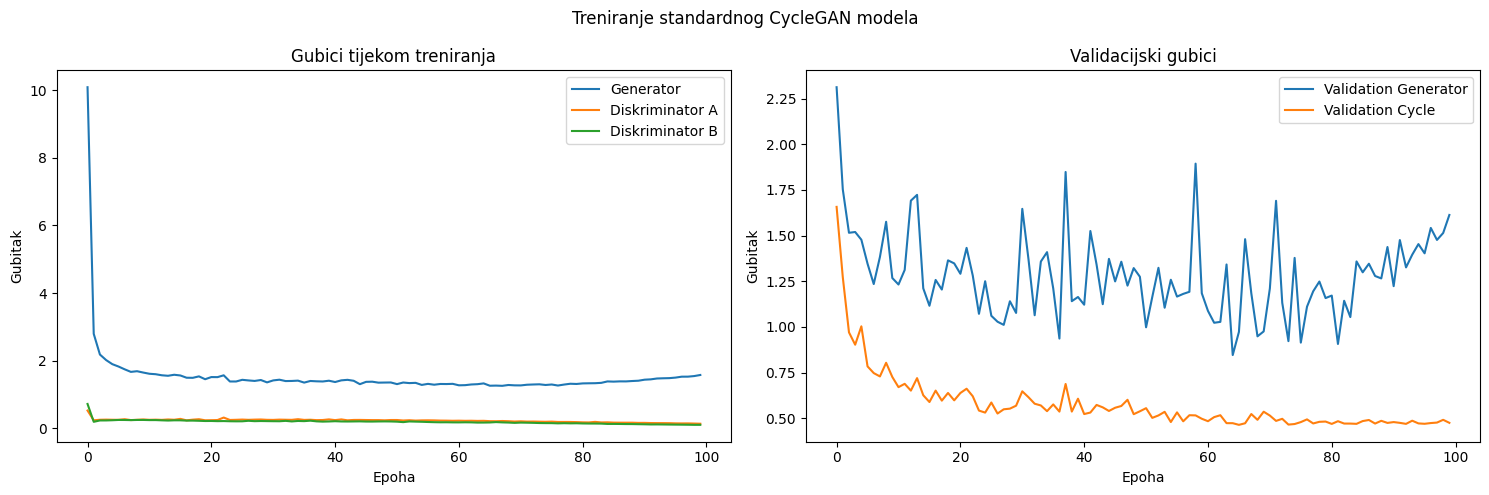

In [9]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

Vizualizacija rezultata na test setu:


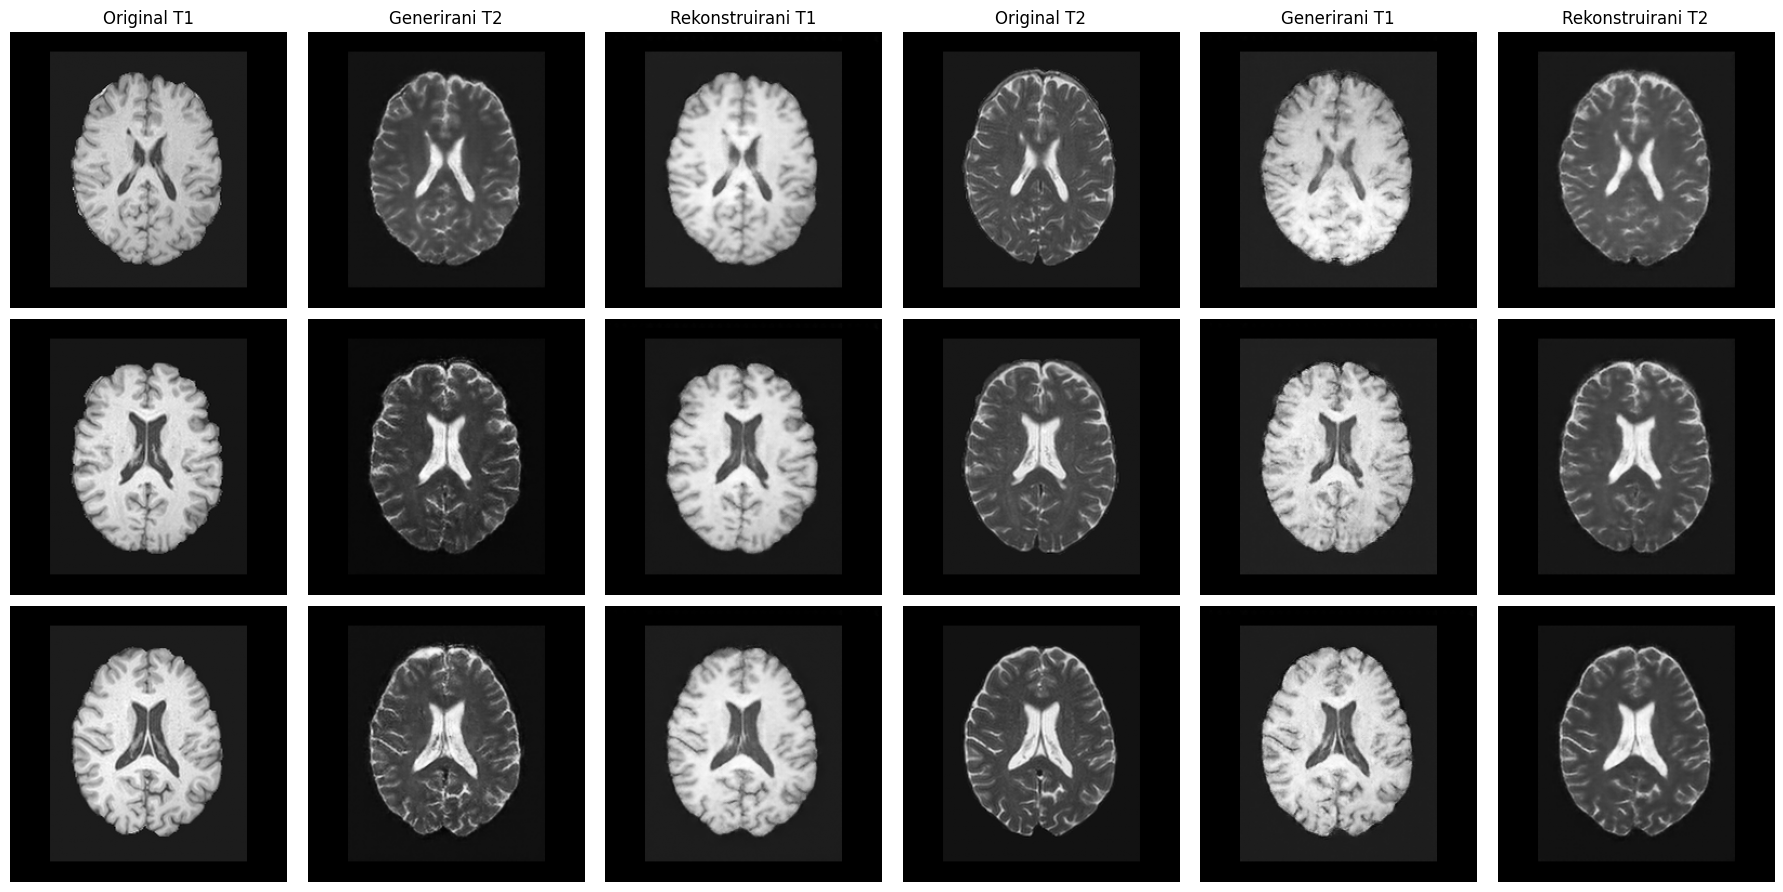

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=3, config=config)

In [46]:
# Definirajte test_model_fixed_crop funkciju direktno u bilježnici
import numpy as np
import torch
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

def calculate_metrics_fixed_crop(real_img, fake_img, crop_height=218, crop_width=182):
    """
    Izračunava metrike nakon obrezivanja na fiksne dimenzije
    
    Args:
        real_img: Originalna slika kao numpy array ili tensor
        fake_img: Generirana slika kao numpy array ili tensor
        crop_height: Visina obreza (182 za originalne MRI slike)
        crop_width: Širina obreza (218 za originalne MRI slike)
        
    Returns:
        Rječnik s metrikama SSIM, MSE i PSNR
    """
    # Pretvaranje u numpy ako je tensor
    if isinstance(real_img, torch.Tensor):
        real_img = real_img.cpu().numpy()
    if isinstance(fake_img, torch.Tensor):
        fake_img = fake_img.cpu().numpy()
    
    # Dobivanje trenutnih dimenzija
    height, width = real_img.shape
    
    # Izračun margina za obrezivanje
    start_h = (height - crop_height) // 2
    start_w = (width - crop_width) // 2
    
    # Obrezivanje slika na središnji dio
    real_cropped = real_img[start_h:start_h+crop_height, start_w:start_w+crop_width]
    fake_cropped = fake_img[start_h:start_h+crop_height, start_w:start_w+crop_width]
    
    # Izračun metrika na obrezanim slikama
    ssim_value = ssim(real_cropped, fake_cropped, data_range=1.0)
    mse = ((real_cropped - fake_cropped) ** 2).mean()
    
    if mse == 0:
        psnr = 100
    else:
        max_pixel = 1.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    return {"ssim": ssim_value, "mse": mse, "psnr": psnr}

def test_model_fixed_crop(G_AB, G_BA, test_dataloader, config, crop_height=182, crop_width=218):
    """
    Testiranje istreniranog modela na test setu s fiksnim obrezivanjem
    
    Args:
        G_AB: Generator za T1->T2 translaciju
        G_BA: Generator za T2->T1 translaciju
        test_dataloader: DataLoader za test set
        config: Konfiguracija modela
        crop_height: Visina obreza (182 za originalne MRI slike)
        crop_width: Širina obreza (218 za originalne MRI slike)
    """
    # Postavi modele u eval način rada
    G_AB.eval()
    G_BA.eval()
    
    # Metrike
    metrics_t1_to_t2 = {"ssim": [], "mse": [], "psnr": []}
    metrics_t2_to_t1 = {"ssim": [], "mse": [], "psnr": []}
    metrics_cycle_t1 = {"ssim": [], "mse": [], "psnr": []}
    metrics_cycle_t2 = {"ssim": [], "mse": [], "psnr": []}
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Evaluacija modela (obrez {crop_height}x{crop_width})"):
            real_A = batch["A"].to(config.device)  # T1
            real_B = batch["B"].to(config.device)  # T2
            
            # Generiraj translacije
            fake_B = G_AB(real_A)  # T1 -> T2
            fake_A = G_BA(real_B)  # T2 -> T1
            
            # Generiraj rekonstrukcije
            rec_A = G_BA(fake_B)  # T1 -> T2 -> T1
            rec_B = G_AB(fake_A)  # T2 -> T1 -> T2
            
            # Normaliziraj za izračun metrika
            real_A_norm = (real_A * 0.5 + 0.5).cpu().numpy()
            real_B_norm = (real_B * 0.5 + 0.5).cpu().numpy()
            fake_A_norm = (fake_A * 0.5 + 0.5).cpu().numpy()
            fake_B_norm = (fake_B * 0.5 + 0.5).cpu().numpy()
            rec_A_norm = (rec_A * 0.5 + 0.5).cpu().numpy()
            rec_B_norm = (rec_B * 0.5 + 0.5).cpu().numpy()
            
            # Izračunaj metrike za svaku sliku u batchu
            for i in range(real_A.size(0)):
                # T1 -> T2 translacija
                metrics = calculate_metrics_fixed_crop(
                    real_B_norm[i].squeeze(), fake_B_norm[i].squeeze(), 
                    crop_height, crop_width)
                metrics_t1_to_t2["ssim"].append(metrics["ssim"])
                metrics_t1_to_t2["mse"].append(metrics["mse"])
                metrics_t1_to_t2["psnr"].append(metrics["psnr"])
                
                # T2 -> T1 translacija
                metrics = calculate_metrics_fixed_crop(
                    real_A_norm[i].squeeze(), fake_A_norm[i].squeeze(),
                    crop_height, crop_width)
                metrics_t2_to_t1["ssim"].append(metrics["ssim"])
                metrics_t2_to_t1["mse"].append(metrics["mse"])
                metrics_t2_to_t1["psnr"].append(metrics["psnr"])
                
                # T1 -> T2 -> T1 ciklus
                metrics = calculate_metrics_fixed_crop(
                    real_A_norm[i].squeeze(), rec_A_norm[i].squeeze(),
                    crop_height, crop_width)
                metrics_cycle_t1["ssim"].append(metrics["ssim"])
                metrics_cycle_t1["mse"].append(metrics["mse"])
                metrics_cycle_t1["psnr"].append(metrics["psnr"])
                
                # T2 -> T1 -> T2 ciklus
                metrics = calculate_metrics_fixed_crop(
                    real_B_norm[i].squeeze(), rec_B_norm[i].squeeze(),
                    crop_height, crop_width)
                metrics_cycle_t2["ssim"].append(metrics["ssim"])
                metrics_cycle_t2["mse"].append(metrics["mse"])
                metrics_cycle_t2["psnr"].append(metrics["psnr"])
    
    # Izračunaj prosječne metrike
    avg_metrics = {
        "T1->T2": {
            "ssim": np.mean(metrics_t1_to_t2["ssim"]),
            "mse": np.mean(metrics_t1_to_t2["mse"]),
            "psnr": np.mean(metrics_t1_to_t2["psnr"])
        },
        "T2->T1": {
            "ssim": np.mean(metrics_t2_to_t1["ssim"]),
            "mse": np.mean(metrics_t2_to_t1["mse"]),
            "psnr": np.mean(metrics_t2_to_t1["psnr"])
        },
        "T1->T2->T1": {
            "ssim": np.mean(metrics_cycle_t1["ssim"]),
            "mse": np.mean(metrics_cycle_t1["mse"]),
            "psnr": np.mean(metrics_cycle_t1["psnr"])
        },
        "T2->T1->T2": {
            "ssim": np.mean(metrics_cycle_t2["ssim"]),
            "mse": np.mean(metrics_cycle_t2["mse"]),
            "psnr": np.mean(metrics_cycle_t2["psnr"])
        }
    }
    
    # Ispiši rezultate
    print(f"\n=== Rezultati evaluacije (obrez {crop_height}x{crop_width}) ===")
    print("T1 -> T2 translacija:")
    print(f"  SSIM: {avg_metrics['T1->T2']['ssim']:.4f}")
    print(f"  MSE: {avg_metrics['T1->T2']['mse']:.6f}")
    print(f"  PSNR: {avg_metrics['T1->T2']['psnr']:.2f} dB")
    
    print("\nT2 -> T1 translacija:")
    print(f"  SSIM: {avg_metrics['T2->T1']['ssim']:.4f}")
    print(f"  MSE: {avg_metrics['T2->T1']['mse']:.6f}")
    print(f"  PSNR: {avg_metrics['T2->T1']['psnr']:.2f} dB")
    
    print("\nT1 -> T2 -> T1 rekonstrukcija:")
    print(f"  SSIM: {avg_metrics['T1->T2->T1']['ssim']:.4f}")
    print(f"  MSE: {avg_metrics['T1->T2->T1']['mse']:.6f}")
    print(f"  PSNR: {avg_metrics['T1->T2->T1']['psnr']:.2f} dB")
    
    print("\nT2 -> T1 -> T2 rekonstrukcija:")
    print(f"  SSIM: {avg_metrics['T2->T1->T2']['ssim']:.4f}")
    print(f"  MSE: {avg_metrics['T2->T1->T2']['mse']:.6f}")
    print(f"  PSNR: {avg_metrics['T2->T1->T2']['psnr']:.2f} dB")

In [47]:
test_model_fixed_crop(
    G_AB, G_BA, test_dataloader, config, crop_height=182, crop_width=218
)

Evaluacija modela (obrez 182x218): 100%|██████████| 22/22 [00:01<00:00, 14.36it/s]


=== Rezultati evaluacije (obrez 182x218) ===
T1 -> T2 translacija:
  SSIM: 0.7317
  MSE: 0.006322
  PSNR: 22.23 dB

T2 -> T1 translacija:
  SSIM: 0.7757
  MSE: 0.006014
  PSNR: 22.51 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9183
  MSE: 0.001348
  PSNR: 28.86 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9111
  MSE: 0.001472
  PSNR: 28.44 dB


In [25]:
best_G_AB = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path = f"{config.checkpoints_dir}/G_AB_best.pth"
best_G_BA_path = f"{config.checkpoints_dir}/G_BA_best.pth"
best_G_AB.load_state_dict(torch.load(best_G_AB_path, map_location=config.device))
best_G_BA.load_state_dict(torch.load(best_G_BA_path, map_location=config.device))

<All keys matched successfully>

In [26]:
print("Testiranje najboljih modela:")
metrics = test_model(best_G_AB, best_G_BA, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 22/22 [00:01<00:00, 11.03it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8067
  MSE: 0.004612
  PSNR: 23.57 dB

T2 -> T1 translacija:
  SSIM: 0.8393
  MSE: 0.004248
  PSNR: 23.95 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9533
  MSE: 0.000744
  PSNR: 31.44 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9516
  MSE: 0.000788
  PSNR: 31.16 dB


In [48]:
metrics = test_model_fixed_crop(best_G_AB, best_G_BA, test_dataloader, config)

Evaluacija modela (obrez 182x218): 100%|██████████| 22/22 [00:01<00:00, 14.09it/s]


=== Rezultati evaluacije (obrez 182x218) ===
T1 -> T2 translacija:
  SSIM: 0.7088
  MSE: 0.007486
  PSNR: 21.47 dB

T2 -> T1 translacija:
  SSIM: 0.7498
  MSE: 0.006880
  PSNR: 21.86 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9247
  MSE: 0.001227
  PSNR: 29.27 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9225
  MSE: 0.001297
  PSNR: 29.00 dB


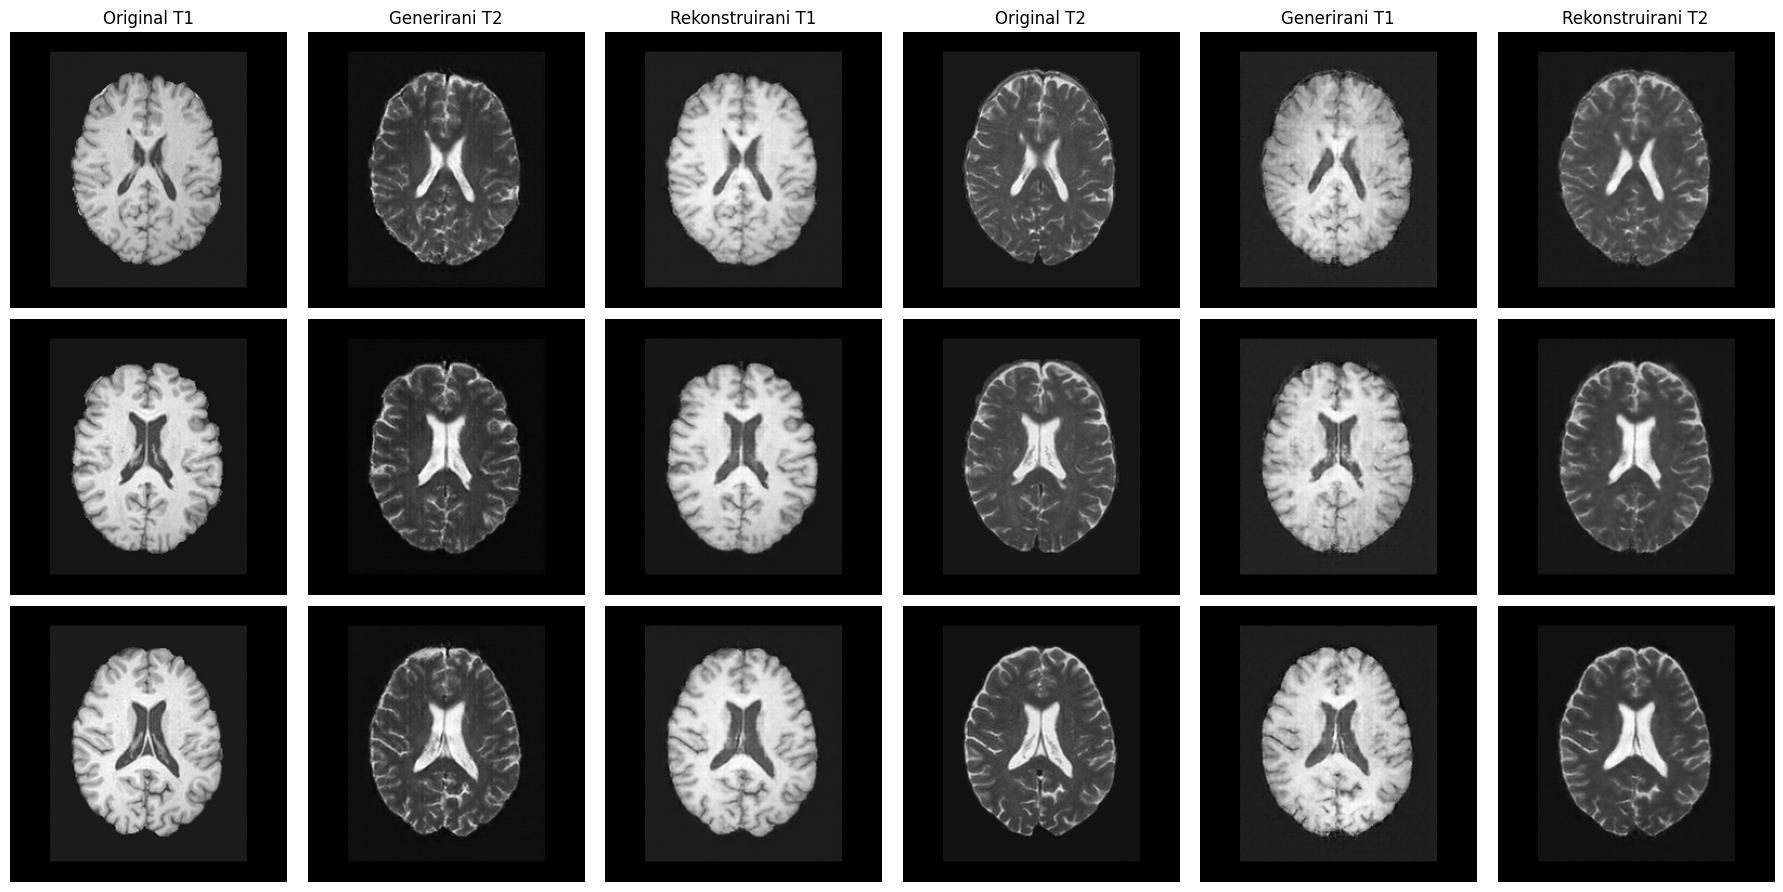

In [28]:
visualize_results(
    best_G_AB, best_G_BA, test_dataloader, num_samples=3, config=config
)